# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# # select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64', no_graphics = True)

In [3]:
# import workspace_utils.py
from workspace_utils import active_session
import numpy as np

import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import copy
from itertools import repeat
import os
import random
import time

# from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

In [6]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     print(env_info.rewards)
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Student Solution

This is based on the Udacity DDPG examples:  
https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum  
https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal

The changes mainly involved:
* Modifying for the Unity API
* Setting the stepping/learning scheme for multiple arms
* Implementing batch normalization
* Shrinking/simplifying the networks
* Detaching networks not requiring gradient computation
* Tuning hyperparameters based on the DDPG paper, the problem/environment, and observed behavior

**First we create the network classes (Actor and Critic):**

In [8]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    # shrink/simplify the network from the DDPG example, for reduced computation
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        # Add batch normalization per the DDPG paper part 3
        self.bn1 = nn.BatchNorm1d(fc1_units)  
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        # Add batch normalization per the DDPG paper part 3
        x = F.relu(self.bn1(self.fc1(state)))  
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    # shrink/simplify the network from the DDPG example, for reduced computation
    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        # Add batch normalization per the DDPG paper part 3
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        # Add batch normalization per the DDPG paper part 3
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


**Then we set hyperparameters and define the Agent class:**

In [9]:
BUFFER_SIZE = int(20 * 1e5)  # larger buffer size to accomodate multiple arms
BATCH_SIZE = 1024  # large batch size for more learning at the cost of more computation
GAMMA = 0.99  # keep high, since we are going out to 1000 time steps
TAU = 1e-3  # per DDPG paper recommendation part 7
LR_ACTOR = 5e-4  # split the difference from LR_CRITIC in DDPG paper part 7
LR_CRITIC = 5e-4  # split the difference from LR_ACTOR in DDPG paper part 7
UPDATE_EVERY = 20  # per the lesson benchmark implementation
UPDATE_QTY = 10  # per the lesson benchmark implementation
WEIGHT_DECAY = 0  # L2 weight decay (from the Udacity DDPG examples)


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC,\
                                           weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)       
    
    def step(self, states, actions, rewards, next_states, dones, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        # Learn every UPDATE_EVERY time steps and...
        # ...if enough samples are available in memory.
        if (step % UPDATE_EVERY == 0) and len(self.memory) > BATCH_SIZE:
            for _ in range(UPDATE_QTY):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        # Use noise to induce exploration, per the DDPG paper part 3
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models.
        # The targets should be detached...
        # ...since we are only computing gradients for the local networks.
        actions_next = self.actor_target(next_states).detach()
        Q_targets_next = self.critic_target(next_states, actions_next).detach()
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # per the lesson benchmark implementation
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # to maximize the loss function (required for gradient ascent)...
        # ...we take the negative of the loss.
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


**Now set the Noise class:**

In [10]:
class OUNoise:  # Use noise to induce exploration, per the DDPG paper part 3
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
    

**Set the memory structure class for storing/sampling experiences (Replay Buffer):**

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",\
                field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).\
                float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).\
                float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).\
                float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).\
                float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).\
                astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

**Define the DDPG algorithm:**

In [12]:
def ddpg(n_episodes = 300, max_t=1000, print_every = 1, min_episodes = 100, min_score = 30):
    scores_all_deque = deque(maxlen = min_episodes)  # the scores for computing performance
    scores_all = []  # the scores for plotting the result
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations  # get the current states (for each arm)
        agent.reset()  # reset the agent for a new episode
        scores = np.zeros(num_agents)  # initialize the scores for the episode
        for t in range(max_t):
            actions = agent.act(states)  # select actions based on the states

            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next states (for each arm)
            rewards = env_info.rewards                         # get rewards (for each arm)
            dones = env_info.local_done                        # see if each arm episode finished

            # Perform an agent step. The step function the lists for each s, a, r, ns, d...
            # ... and passes the time step
            agent.step(states, actions, rewards, next_states, dones, t)

            states = next_states  # update the current states
            scores += rewards  # log the scores for the episode, for each arm
            if any(dones):  # break the episode if any arm finishes
                print('end of episode {} for arm {}'.format(i_episode, np.where(np.array(dones) == True)[0]))
                break 
        episode_mean = np.mean(scores)
        scores_all_deque.append(episode_mean)
        scores_all.append(episode_mean)
        batch_mean = np.mean(scores_all_deque)  # compute performance for episode
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')  # save actor weights
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')  # save critic weights
        if i_episode % print_every == 0:
            print('\rEpisode {}  Episode Score {:.3f}  Cumulative Average Score: {:.3f}  time: {}'.\
                  format(i_episode, episode_mean, batch_mean, time.time() - start_time))
        if batch_mean >= min_score and i_episode >= min_episodes:
            print('\nEnvironment solved in {:d} episodes!  Cumulative100 Average Score: {:.3f}'.\
                  format(i_episode, batch_mean))
            break

    return scores_all

**Set the environment and device:**

In [13]:
# create the multi-arm environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64', no_graphics = True)

# create the brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get the basic environment info
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


**Now within an active session (for non-idling workspaces):**
* create the networks, agent, noise process, and replay buffer based on their classes
* train
* plot results

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 1  Episode Score 0.480  Cumulative Average Score: 0.480  time: 33.560805797576904
Episode 2  Episode Score 0.711  Cumulative Average Score: 0.596  time: 58.11936855316162
Episode 3  Episode Score 0.677  Cumulative Average Score: 0.623  time: 79.47827792167664
Episode 4  Episode Score 0.809  Cumulative Average Score: 0.669  time: 101.20164465904236
Episode 5  Episode Score 0.790  Cumulative Average Score: 0.694  time: 123.23350882530212
Episode 6  Episode Score 0.927  Cumulative Average Score: 0.733  time: 145.59942865371704
Episode 7  Episode Score 1.098  Cumulative Average Score: 0.785  time: 168.2777259349823
Episode 8  Episode Score 1.301  Cumulative Average Score: 0.849  time: 191.42365908622742
Episode 9  Episode Score 1.223  Cumulative Average Score: 0.891  time: 214.89563989639282
Episode 10  Episode Score 1.330  Cumulative Average Score: 0.935  time: 239.06217002868652
Episode 11  Episode Score 1.684  Cumulative Average Score: 1.003  time: 263.3274230957031
Episode 12  

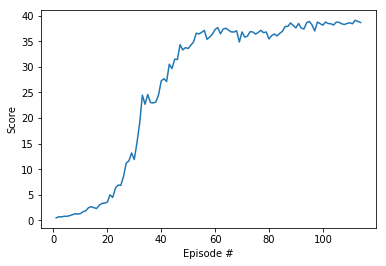

finish time: 7764.258405447006


In [14]:
if __name__ == '__main__':
    with active_session():
        # initialize an agent
        agent = Agent(state_size = state_size, action_size = action_size, random_seed = 2, num_agents = num_agents)

        start_time = time.time()

        scores_all = ddpg()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(1, len(scores_all)+1), scores_all)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()

        print('finish time: {}'.format(time.time() - start_time))

In [15]:
#         env.close()